# Experiment 3 MobileNetV2

In [1]:
!pip install --upgrade pip
!pip install mediapipe==0.10.21 tensorflow==2.18.0 tensorflowjs==4.22.0 protobuf==4.25.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 72.4 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
INFO: pip is looking at multiple versions of ydf to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 162.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 23.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    

In [1]:
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import mediapipe as mp

random.seed(42028)

In [ ]:
!nvidia-smi

Tue May 27 06:40:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   50C    P8             17W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
print("TF Version:", tf.__version__)
print("GPU:", tf.config.list_physical_devices('GPU'))

TF Version: 2.18.0
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
PROJECT_DIR = "/content/drive/Shareddrives/OmniClick Team"
DATA_ROOT_DIR = os.path.join(PROJECT_DIR, "datasets")
COLUMBIA_DATA_DIR = os.path.join(DATA_ROOT_DIR, 'ColumbiaGazeProcessed')

UNITY_BEST_MODEL_PATH = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_unity_best.keras")
UNITY_LAST_MODEL_PATH = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_unity_last.keras")
UNITY_TFJS_MODEL_DIR = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_unity_tfjs")
UNITY_TF_SAVE_MODEL_DIR = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_unity_tf")

COLUMBIA_BEST_MODEL_PATH = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_gaze_columbia_best.h5")
COLUMBIA_LAST_MODEL_PATH = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_gaze_columbia_last.h5")
COLUMBIA_TFJS_MODEL_PATH = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_gaze_columbia_tfjs")
COLUMBIA_TF_SAVE_MODEL_DIR = os.path.join(PROJECT_DIR, "notebooks/weights/mobilenetv2_columbia_tf")

In [5]:
u_best_model = tf.keras.models.load_model(UNITY_BEST_MODEL_PATH)
u_last_model = tf.keras.models.load_model(UNITY_LAST_MODEL_PATH)

In [6]:
import cv2
from PIL import Image

def extract_right_eye_from_directory(src_root, dst_root, target_size=(96, 96), margin=10):
    """
    Batch extract left-eye regions from the Columbia Gaze dataset.
    Args:
      src_root (str): Path to the original Columbia dataset directory (organized by class folders).
      dst_root (str): Path to save the cropped left-eye images (maintains same class structure).
      target_size (tuple): Output image resolution after cropping and resizing.
      margin (int): Number of pixels to expand around the detected eye region bounding box.
    """
    os.makedirs(dst_root, exist_ok=True)

    mp_face_mesh = mp.solutions.face_mesh

    with mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=False, max_num_faces=1) as face_mesh:
        for class_name in sorted(os.listdir(src_root)):
            src_class_path = os.path.join(src_root, class_name)
            dst_class_path = os.path.join(dst_root, class_name)
            os.makedirs(dst_class_path, exist_ok=True)

            for fname in os.listdir(src_class_path):
                src_img_path = os.path.join(src_class_path, fname)
                dst_img_path = os.path.join(dst_class_path, fname)

                try:
                    image = cv2.imread(src_img_path)
                    if image is None:
                        continue
                    rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    results = face_mesh.process(rgb)

                    if results.multi_face_landmarks:
                        h, w = image.shape[:2]
                        landmarks = results.multi_face_landmarks[0].landmark
                        right_eye_indices = [362, 263, 386, 374]
                        pts = np.array([[int(landmarks[i].x * w), int(landmarks[i].y * h)] for i in right_eye_indices])
                        x, y, w_box, h_box = cv2.boundingRect(pts)
                        x, y = max(0, x - margin), max(0, y - margin)
                        w_box += 2 * margin
                        h_box += 2 * margin
                        crop = image[y:y + h_box, x:x + w_box]
                        crop_resized = cv2.resize(crop, target_size)
                        Image.fromarray(cv2.cvtColor(crop_resized, cv2.COLOR_BGR2RGB)).save(dst_img_path)

                except Exception as e:
                    print(f"❌ Error processing {src_img_path}: {e}")

In [ ]:
!ls

drive  sample_data


In [ ]:
extract_right_eye_from_directory(
    src_root="/content/drive/Shareddrives/OmniClick Team/datasets/ColumbiaGazeProcessed/train",
    dst_root="/content/drive/Shareddrives/OmniClick Team/datasets/ColumbiaGaze_RightEye/train"
)

extract_right_eye_from_directory(
    src_root="/content/drive/Shareddrives/OmniClick Team/datasets/ColumbiaGazeProcessed/val",
    dst_root="/content/drive/Shareddrives/OmniClick Team/datasets/ColumbiaGaze_RightEye/val"
)

extract_right_eye_from_directory(
    src_root="/content/drive/Shareddrives/OmniClick Team/datasets/ColumbiaGazeProcessed/test",
    dst_root="/content/drive/Shareddrives/OmniClick Team/datasets/ColumbiaGaze_RightEye/test"
)

In [8]:
IMG_SIZE = (96, 96)
BATCH_SIZE = 16

COLUMBIA_LEFT_EYE_DIR = "/content/drive/Shareddrives/OmniClick Team/datasets/ColumbiaGaze_LeftEye"

columbia_train_dir = os.path.join(COLUMBIA_LEFT_EYE_DIR, 'train')
columbia_val_dir = os.path.join(COLUMBIA_LEFT_EYE_DIR, 'val')
columbia_test_dir = os.path.join(COLUMBIA_LEFT_EYE_DIR, 'test')

columbia_class_names = sorted(os.listdir(columbia_train_dir))
columbia_class_indices = {name: idx for idx, name in enumerate(columbia_class_names)}
NUM_CLASSES_COLUMBIA = len(columbia_class_names)

# For Columbia set class imbalance
columbia_y_train = []
for class_name in columbia_class_names:
    class_path = os.path.join(columbia_train_dir, class_name)
    columbia_y_train.extend([columbia_class_indices[class_name]] * len(os.listdir(class_path)))

# Compute weights
columbia_class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(columbia_y_train), y=columbia_y_train)
columbia_class_weights = dict(enumerate(columbia_class_weights_array))

center_index = columbia_class_indices['center']
columbia_class_weights[center_index] *= 1.5

# Data Aug for Columbia set
columbia_train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    brightness_range=[0.7, 1.3],
    zoom_range=0.1,
    horizontal_flip=True
).flow_from_directory(
    columbia_train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
columbia_val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    columbia_val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
columbia_test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    columbia_test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Checkpoints
callbacks = [
    ModelCheckpoint(
        COLUMBIA_BEST_MODEL_PATH,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    ModelCheckpoint(
        COLUMBIA_LAST_MODEL_PATH,
        save_best_only=False,
        save_weights_only=False,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True
    )
]

Found 1129 images belonging to 9 classes.
Found 262 images belonging to 9 classes.
Found 258 images belonging to 9 classes.


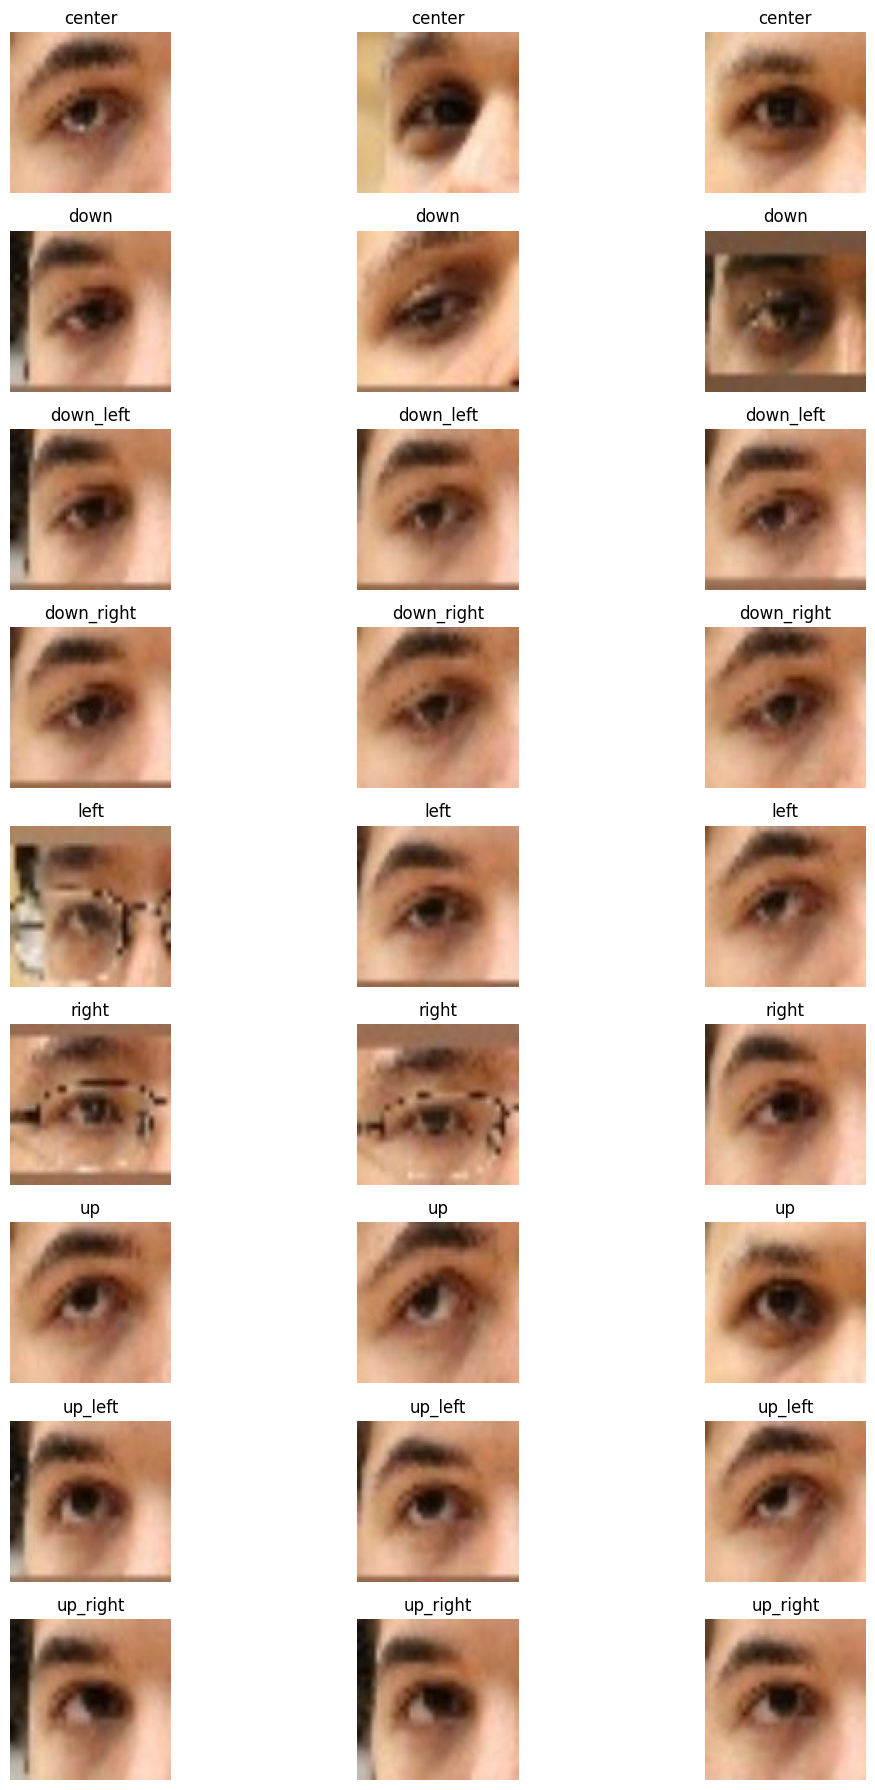

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

def show_sample_images_from_folder(folder_path, class_names, images_per_class=3, img_size=(96, 96)):
    plt.figure(figsize=(12, len(class_names) * 2))
    i = 1
    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        image_files = sorted(os.listdir(class_path))[:images_per_class]
        for file in image_files:
            img = Image.open(os.path.join(class_path, file)).resize(img_size)
            plt.subplot(len(class_names), images_per_class, i)
            plt.imshow(img)
            plt.title(f"{class_name}")
            plt.axis("off")
            i += 1
    plt.tight_layout()
    plt.show()

show_sample_images_from_folder(columbia_train_dir, columbia_class_names, images_per_class=3)

In [9]:
from tensorflow.keras.models import load_model

UNITY_MODEL_PATH = os.path.join(PROJECT_DIR, 'notebooks/weights/mobilenetv2_unity_best.keras')
model = load_model(UNITY_MODEL_PATH)

x = model.layers[-3].output
x = Dense(128, activation='relu', name='fc1')(x)
x = Dropout(0.4, name='dropout1')(x)
output = Dense(9, activation='softmax', name='columbia_output')(x)

model = Model(inputs=model.input, outputs=output)

In [10]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
# Train
history = model.fit(
    columbia_train_gen,
    validation_data=columbia_val_gen,
    epochs=1000,
    callbacks=callbacks,
    class_weight=columbia_class_weights
)
model.export(COLUMBIA_TF_SAVE_MODEL_DIR)

Epoch 1/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1778 - loss: 2.2312
Epoch 1: val_loss did not improve from 2.12927

Epoch 1: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.1778 - loss: 2.2311 - val_accuracy: 0.1298 - val_loss: 2.1305
Epoch 2/1000
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1562 - loss: 2.2138
Epoch 2: val_loss did not improve from 2.12927

Epoch 2: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.1566 - loss: 2.2140 - val_accuracy: 0.1260 - val_loss: 2.1313
Epoch 3/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1791 - loss: 2.1426
Epoch 3: val_loss improved from 2.12927 to 2.12193, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 3: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - accuracy: 0.1790 - loss: 2.1434 - val_accuracy: 0.1412 - val_loss: 2.1219
Epoch 4/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.1768 - loss: 2.2029
Epoch 4: val_loss improved from 2.12193 to 2.11431, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 4: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.1769 - loss: 2.2028 - val_accuracy: 0.1450 - val_loss: 2.1143
Epoch 5/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1970 - loss: 2.1429
Epoch 5: val_loss improved from 2.11431 to 2.10644, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 5: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.1970 - loss: 2.1435 - val_accuracy: 0.1527 - val_loss: 2.1064
Epoch 6/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1637 - loss: 2.2265
Epoch 6: val_loss improved from 2.10644 to 2.09230, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 6: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - accuracy: 0.1638 - loss: 2.2260 - val_accuracy: 0.1832 - val_loss: 2.0923
Epoch 7/1000
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2151 - loss: 2.2008
Epoch 7: val_loss improved from 2.09230 to 2.08486, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 7: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.2145 - loss: 2.1998 - val_accuracy: 0.1756 - val_loss: 2.0849
Epoch 8/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.1993 - loss: 2.1861
Epoch 8: val_loss improved from 2.08486 to 2.07818, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 8: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.1992 - loss: 2.1857 - val_accuracy: 0.1794 - val_loss: 2.0782
Epoch 9/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1725 - loss: 2.1764
Epoch 9: val_loss improved from 2.07818 to 2.06601, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 9: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.1726 - loss: 2.1760 - val_accuracy: 0.1908 - val_loss: 2.0660
Epoch 10/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1842 - loss: 2.1436
Epoch 10: val_loss improved from 2.06601 to 2.05927, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 10: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.1842 - loss: 2.1436 - val_accuracy: 0.1947 - val_loss: 2.0593
Epoch 11/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2004 - loss: 2.1400
Epoch 11: val_loss improved from 2.05927 to 2.04856, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 11: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.2006 - loss: 2.1399 - val_accuracy: 0.2061 - val_loss: 2.0486
Epoch 12/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.1936 - loss: 2.1745
Epoch 12: val_loss improved from 2.04856 to 2.04199, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 12: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.1938 - loss: 2.1735 - val_accuracy: 0.2137 - val_loss: 2.0420
Epoch 13/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1962 - loss: 2.1989
Epoch 13: val_loss improved from 2.04199 to 2.03092, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 13: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.1965 - loss: 2.1978 - val_accuracy: 0.2137 - val_loss: 2.0309
Epoch 14/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2137 - loss: 2.1600
Epoch 14: val_loss improved from 2.03092 to 2.02207, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 14: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.2136 - loss: 2.1595 - val_accuracy: 0.2176 - val_loss: 2.0221
Epoch 15/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2161 - loss: 2.1441
Epoch 15: val_loss improved from 2.02207 to 2.01756, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 15: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.2160 - loss: 2.1436 - val_accuracy: 0.2214 - val_loss: 2.0176
Epoch 16/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2195 - loss: 2.1235
Epoch 16: val_loss improved from 2.01756 to 2.00680, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 16: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.2193 - loss: 2.1233 - val_accuracy: 0.2252 - val_loss: 2.0068
Epoch 17/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2096 - loss: 2.0990
Epoch 17: val_loss improved from 2.00680 to 2.00150, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 17: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.2096 - loss: 2.0987 - val_accuracy: 0.2290 - val_loss: 2.0015
Epoch 18/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.1716 - loss: 2.0819
Epoch 18: val_loss improved from 2.00150 to 1.99029, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 18: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.1720 - loss: 2.0820 - val_accuracy: 0.2214 - val_loss: 1.9903
Epoch 19/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2391 - loss: 2.0239
Epoch 19: val_loss improved from 1.99029 to 1.98324, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 19: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.2390 - loss: 2.0242 - val_accuracy: 0.2252 - val_loss: 1.9832
Epoch 20/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2059 - loss: 2.0322
Epoch 20: val_loss improved from 1.98324 to 1.96929, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 20: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.2062 - loss: 2.0322 - val_accuracy: 0.2328 - val_loss: 1.9693
Epoch 21/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2174 - loss: 2.0269
Epoch 21: val_loss improved from 1.96929 to 1.95647, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 21: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.2177 - loss: 2.0269 - val_accuracy: 0.2099 - val_loss: 1.9565
Epoch 22/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2402 - loss: 2.0463
Epoch 22: val_loss improved from 1.95647 to 1.94560, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 22: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.2400 - loss: 2.0465 - val_accuracy: 0.2137 - val_loss: 1.9456
Epoch 23/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2396 - loss: 1.9436
Epoch 23: val_loss improved from 1.94560 to 1.92583, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 23: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.2397 - loss: 1.9444 - val_accuracy: 0.2366 - val_loss: 1.9258
Epoch 24/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2605 - loss: 1.9375
Epoch 24: val_loss improved from 1.92583 to 1.92277, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 24: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.2605 - loss: 1.9383 - val_accuracy: 0.2328 - val_loss: 1.9228
Epoch 25/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2178 - loss: 2.1220
Epoch 25: val_loss did not improve from 1.92277

Epoch 25: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.2180 - loss: 2.1209 - val_accuracy: 0.2290 - val_loss: 1.9274
Epoch 26/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2907 - loss: 1.9802
Epoch 26: val_loss improved from 1.92277 to 1.91633, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 26: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.2904 - loss: 1.9798 - val_accuracy: 0.2366 - val_loss: 1.9163
Epoch 27/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2728 - loss: 1.9729
Epoch 27: val_loss improved from 1.91633 to 1.90059, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 27: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.2726 - loss: 1.9728 - val_accuracy: 0.2595 - val_loss: 1.9006
Epoch 28/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2736 - loss: 1.9171
Epoch 28: val_loss improved from 1.90059 to 1.88896, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 28: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.2736 - loss: 1.9175 - val_accuracy: 0.2824 - val_loss: 1.8890
Epoch 29/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2656 - loss: 1.9365
Epoch 29: val_loss improved from 1.88896 to 1.88340, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 29: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.2654 - loss: 1.9368 - val_accuracy: 0.2710 - val_loss: 1.8834
Epoch 30/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2664 - loss: 1.9720
Epoch 30: val_loss improved from 1.88340 to 1.87534, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 30: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.2665 - loss: 1.9717 - val_accuracy: 0.2595 - val_loss: 1.8753
Epoch 31/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2710 - loss: 1.9303
Epoch 31: val_loss improved from 1.87534 to 1.86715, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 31: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.2710 - loss: 1.9306 - val_accuracy: 0.2634 - val_loss: 1.8671
Epoch 32/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2993 - loss: 1.9083
Epoch 32: val_loss improved from 1.86715 to 1.85291, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 32: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.2992 - loss: 1.9083 - val_accuracy: 0.2672 - val_loss: 1.8529
Epoch 33/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2588 - loss: 1.9613
Epoch 33: val_loss improved from 1.85291 to 1.85006, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 33: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.2589 - loss: 1.9607 - val_accuracy: 0.2786 - val_loss: 1.8501
Epoch 34/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2812 - loss: 1.8452
Epoch 34: val_loss improved from 1.85006 to 1.83855, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 34: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.2810 - loss: 1.8466 - val_accuracy: 0.2824 - val_loss: 1.8385
Epoch 35/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2819 - loss: 1.9035
Epoch 35: val_loss improved from 1.83855 to 1.83562, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 35: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.2819 - loss: 1.9036 - val_accuracy: 0.2786 - val_loss: 1.8356
Epoch 36/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2862 - loss: 1.9062
Epoch 36: val_loss improved from 1.83562 to 1.83077, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 36: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.2861 - loss: 1.9062 - val_accuracy: 0.2595 - val_loss: 1.8308
Epoch 37/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3018 - loss: 1.8042
Epoch 37: val_loss improved from 1.83077 to 1.82558, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 37: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step - accuracy: 0.3016 - loss: 1.8049 - val_accuracy: 0.2634 - val_loss: 1.8256
Epoch 38/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2892 - loss: 1.8121
Epoch 38: val_loss improved from 1.82558 to 1.79911, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 38: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.2891 - loss: 1.8129 - val_accuracy: 0.2977 - val_loss: 1.7991
Epoch 39/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3147 - loss: 1.8654
Epoch 39: val_loss improved from 1.79911 to 1.79410, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 39: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.3145 - loss: 1.8650 - val_accuracy: 0.2939 - val_loss: 1.7941
Epoch 40/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2831 - loss: 1.8094
Epoch 40: val_loss improved from 1.79410 to 1.77628, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 40: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.2831 - loss: 1.8101 - val_accuracy: 0.3206 - val_loss: 1.7763
Epoch 41/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3194 - loss: 1.7215
Epoch 41: val_loss improved from 1.77628 to 1.77371, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 41: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.3196 - loss: 1.7225 - val_accuracy: 0.3206 - val_loss: 1.7737
Epoch 42/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3149 - loss: 1.8052
Epoch 42: val_loss improved from 1.77371 to 1.76482, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 42: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.3151 - loss: 1.8050 - val_accuracy: 0.3206 - val_loss: 1.7648
Epoch 43/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3232 - loss: 1.7584
Epoch 43: val_loss improved from 1.76482 to 1.75057, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 43: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.3233 - loss: 1.7583 - val_accuracy: 0.3244 - val_loss: 1.7506
Epoch 44/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3085 - loss: 1.8149
Epoch 44: val_loss did not improve from 1.75057

Epoch 44: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.3087 - loss: 1.8148 - val_accuracy: 0.3130 - val_loss: 1.7508
Epoch 45/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3220 - loss: 1.7487
Epoch 45: val_loss improved from 1.75057 to 1.74809, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 45: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.3221 - loss: 1.7485 - val_accuracy: 0.3053 - val_loss: 1.7481
Epoch 46/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3249 - loss: 1.8057
Epoch 46: val_loss improved from 1.74809 to 1.72902, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 46: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.3250 - loss: 1.8046 - val_accuracy: 0.3206 - val_loss: 1.7290
Epoch 47/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3630 - loss: 1.6182
Epoch 47: val_loss improved from 1.72902 to 1.71986, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 47: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.3629 - loss: 1.6192 - val_accuracy: 0.3206 - val_loss: 1.7199
Epoch 48/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3660 - loss: 1.6798
Epoch 48: val_loss did not improve from 1.71986

Epoch 48: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.3657 - loss: 1.6806 - val_accuracy: 0.3130 - val_loss: 1.7359
Epoch 49/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3850 - loss: 1.6789
Epoch 49: val_loss did not improve from 1.71986

Epoch 49: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.3846 - loss: 1.6792 - val_accuracy: 0.3282 - val_loss: 1.7232
Epoch 50/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3196 - loss: 1.7450
Epoch 50: val_loss improved from 1.71986 to 1.70713, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 50: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.3197 - loss: 1.7446 - val_accuracy: 0.3282 - val_loss: 1.7071
Epoch 51/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3489 - loss: 1.7568
Epoch 51: val_loss improved from 1.70713 to 1.67763, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 51: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.3488 - loss: 1.7568 - val_accuracy: 0.3511 - val_loss: 1.6776
Epoch 52/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3569 - loss: 1.6249
Epoch 52: val_loss improved from 1.67763 to 1.67370, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 52: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.3568 - loss: 1.6254 - val_accuracy: 0.3321 - val_loss: 1.6737
Epoch 53/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3651 - loss: 1.7503
Epoch 53: val_loss improved from 1.67370 to 1.67045, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 53: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 106ms/step - accuracy: 0.3649 - loss: 1.7495 - val_accuracy: 0.3473 - val_loss: 1.6704
Epoch 54/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3734 - loss: 1.7217
Epoch 54: val_loss did not improve from 1.67045

Epoch 54: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.3733 - loss: 1.7208 - val_accuracy: 0.3321 - val_loss: 1.6720
Epoch 55/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3846 - loss: 1.6113
Epoch 55: val_loss improved from 1.67045 to 1.66540, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 55: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.3843 - loss: 1.6126 - val_accuracy: 0.3435 - val_loss: 1.6654
Epoch 56/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4040 - loss: 1.6130
Epoch 56: val_loss did not improve from 1.66540

Epoch 56: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.4035 - loss: 1.6136 - val_accuracy: 0.3397 - val_loss: 1.6734
Epoch 57/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3805 - loss: 1.6255
Epoch 57: val_loss did not improve from 1.66540

Epoch 57: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.3804 - loss: 1.6252 - val_accuracy: 0.3206 - val_loss: 1.6813
Epoch 58/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3649 - loss: 1.5633
Epoch 58: val_loss did not improve from 1.66540

Epoch 58: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.3653 - loss: 1.5636 - val_accuracy: 0.3206 - val_loss: 1.6789
Epoch 59/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4057 - loss: 1.6259
Epoch 59: val_loss did not improve from 1.66540

Epoch 59: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.4055 - loss: 1.6254 - val_accuracy: 0.3321 - val_loss: 1.6818
Epoch 60/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3591 - loss: 1.6406
Epoch 60: val_loss improved from 1.66540 to 1.66432, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 60: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.3592 - loss: 1.6403 - val_accuracy: 0.3473 - val_loss: 1.6643
Epoch 61/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3927 - loss: 1.5719
Epoch 61: val_loss improved from 1.66432 to 1.63574, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 61: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.3928 - loss: 1.5718 - val_accuracy: 0.3511 - val_loss: 1.6357
Epoch 62/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3821 - loss: 1.5958
Epoch 62: val_loss improved from 1.63574 to 1.62531, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 62: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.3823 - loss: 1.5957 - val_accuracy: 0.3588 - val_loss: 1.6253
Epoch 63/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4295 - loss: 1.5079
Epoch 63: val_loss improved from 1.62531 to 1.60218, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 63: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.4295 - loss: 1.5078 - val_accuracy: 0.3817 - val_loss: 1.6022
Epoch 64/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3849 - loss: 1.5900
Epoch 64: val_loss did not improve from 1.60218

Epoch 64: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.3853 - loss: 1.5890 - val_accuracy: 0.3779 - val_loss: 1.6059
Epoch 65/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3598 - loss: 1.5843
Epoch 65: val_loss improved from 1.60218 to 1.58816, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 65: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.3605 - loss: 1.5833 - val_accuracy: 0.4046 - val_loss: 1.5882
Epoch 66/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4166 - loss: 1.4775
Epoch 66: val_loss improved from 1.58816 to 1.57709, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 66: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.4165 - loss: 1.4781 - val_accuracy: 0.4122 - val_loss: 1.5771
Epoch 67/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4334 - loss: 1.5085
Epoch 67: val_loss improved from 1.57709 to 1.56127, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 67: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.4332 - loss: 1.5082 - val_accuracy: 0.4122 - val_loss: 1.5613
Epoch 68/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4622 - loss: 1.4000
Epoch 68: val_loss did not improve from 1.56127

Epoch 68: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.4619 - loss: 1.4012 - val_accuracy: 0.4046 - val_loss: 1.5661
Epoch 69/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4349 - loss: 1.4637
Epoch 69: val_loss improved from 1.56127 to 1.54064, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 69: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.4349 - loss: 1.4636 - val_accuracy: 0.4160 - val_loss: 1.5406
Epoch 70/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4290 - loss: 1.4075
Epoch 70: val_loss improved from 1.54064 to 1.52888, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 70: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.4290 - loss: 1.4080 - val_accuracy: 0.4275 - val_loss: 1.5289
Epoch 71/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4141 - loss: 1.5214
Epoch 71: val_loss improved from 1.52888 to 1.52717, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 71: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.4141 - loss: 1.5208 - val_accuracy: 0.4275 - val_loss: 1.5272
Epoch 72/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4469 - loss: 1.4724
Epoch 72: val_loss improved from 1.52717 to 1.49738, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 72: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.4468 - loss: 1.4725 - val_accuracy: 0.4237 - val_loss: 1.4974
Epoch 73/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4912 - loss: 1.4089
Epoch 73: val_loss did not improve from 1.49738

Epoch 73: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.4906 - loss: 1.4093 - val_accuracy: 0.4008 - val_loss: 1.5331
Epoch 74/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4563 - loss: 1.4281
Epoch 74: val_loss did not improve from 1.49738

Epoch 74: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.4561 - loss: 1.4285 - val_accuracy: 0.4275 - val_loss: 1.5049
Epoch 75/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4402 - loss: 1.4399
Epoch 75: val_loss improved from 1.49738 to 1.48670, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 75: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.4406 - loss: 1.4396 - val_accuracy: 0.4275 - val_loss: 1.4867
Epoch 76/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4634 - loss: 1.4115
Epoch 76: val_loss did not improve from 1.48670

Epoch 76: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.4634 - loss: 1.4112 - val_accuracy: 0.4237 - val_loss: 1.4899
Epoch 77/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.4728 - loss: 1.3974
Epoch 77: val_loss improved from 1.48670 to 1.47322, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 77: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.4726 - loss: 1.3971 - val_accuracy: 0.4313 - val_loss: 1.4732
Epoch 78/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4998 - loss: 1.2914
Epoch 78: val_loss did not improve from 1.47322

Epoch 78: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.4998 - loss: 1.2916 - val_accuracy: 0.4351 - val_loss: 1.4818
Epoch 79/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4989 - loss: 1.3550
Epoch 79: val_loss improved from 1.47322 to 1.46363, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 79: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.4987 - loss: 1.3546 - val_accuracy: 0.4389 - val_loss: 1.4636
Epoch 80/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4625 - loss: 1.3329
Epoch 80: val_loss improved from 1.46363 to 1.46267, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 80: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.4624 - loss: 1.3337 - val_accuracy: 0.4237 - val_loss: 1.4627
Epoch 81/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4880 - loss: 1.3729
Epoch 81: val_loss improved from 1.46267 to 1.45171, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 81: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.4883 - loss: 1.3720 - val_accuracy: 0.4466 - val_loss: 1.4517
Epoch 82/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5708 - loss: 1.1898
Epoch 82: val_loss improved from 1.45171 to 1.45155, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 82: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.5703 - loss: 1.1906 - val_accuracy: 0.4351 - val_loss: 1.4516
Epoch 83/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4826 - loss: 1.3656
Epoch 83: val_loss improved from 1.45155 to 1.44540, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 83: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.4827 - loss: 1.3653 - val_accuracy: 0.4198 - val_loss: 1.4454
Epoch 84/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5438 - loss: 1.1834
Epoch 84: val_loss improved from 1.44540 to 1.44125, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 84: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.5434 - loss: 1.1840 - val_accuracy: 0.4427 - val_loss: 1.4413
Epoch 85/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5117 - loss: 1.3425
Epoch 85: val_loss did not improve from 1.44125

Epoch 85: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.5117 - loss: 1.3420 - val_accuracy: 0.4351 - val_loss: 1.4441
Epoch 86/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5054 - loss: 1.3477
Epoch 86: val_loss improved from 1.44125 to 1.41874, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 86: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.5054 - loss: 1.3466 - val_accuracy: 0.4695 - val_loss: 1.4187
Epoch 87/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5161 - loss: 1.2963
Epoch 87: val_loss did not improve from 1.41874

Epoch 87: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.5162 - loss: 1.2957 - val_accuracy: 0.4427 - val_loss: 1.4204
Epoch 88/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5509 - loss: 1.1916
Epoch 88: val_loss improved from 1.41874 to 1.41799, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 88: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.5509 - loss: 1.1922 - val_accuracy: 0.4504 - val_loss: 1.4180
Epoch 89/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5413 - loss: 1.1995
Epoch 89: val_loss improved from 1.41799 to 1.39703, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 89: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.5412 - loss: 1.1996 - val_accuracy: 0.4809 - val_loss: 1.3970
Epoch 90/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5450 - loss: 1.2110
Epoch 90: val_loss improved from 1.39703 to 1.37917, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 90: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.5450 - loss: 1.2110 - val_accuracy: 0.4847 - val_loss: 1.3792
Epoch 91/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5141 - loss: 1.2158
Epoch 91: val_loss improved from 1.37917 to 1.36996, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 91: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - accuracy: 0.5145 - loss: 1.2156 - val_accuracy: 0.5038 - val_loss: 1.3700
Epoch 92/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5781 - loss: 1.1615
Epoch 92: val_loss improved from 1.36996 to 1.36340, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 92: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.5778 - loss: 1.1620 - val_accuracy: 0.5000 - val_loss: 1.3634
Epoch 93/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5516 - loss: 1.1100
Epoch 93: val_loss improved from 1.36340 to 1.35021, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 93: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.5515 - loss: 1.1105 - val_accuracy: 0.5076 - val_loss: 1.3502
Epoch 94/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5938 - loss: 1.0716
Epoch 94: val_loss did not improve from 1.35021

Epoch 94: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - accuracy: 0.5936 - loss: 1.0722 - val_accuracy: 0.4809 - val_loss: 1.4177
Epoch 95/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5514 - loss: 1.2442
Epoch 95: val_loss did not improve from 1.35021

Epoch 95: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.5513 - loss: 1.2440 - val_accuracy: 0.4962 - val_loss: 1.3882
Epoch 96/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5297 - loss: 1.2953
Epoch 96: val_loss did not improve from 1.35021

Epoch 96: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.5301 - loss: 1.2935 - val_accuracy: 0.4771 - val_loss: 1.3818
Epoch 97/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5757 - loss: 1.1457
Epoch 97: val_loss did not improve from 1.35021

Epoch 97: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.5756 - loss: 1.1459 - val_accuracy: 0.4809 - val_loss: 1.3806
Epoch 98/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5775 - loss: 1.1469
Epoch 98: val_loss did not improve from 1.35021

Epoch 98: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.5776 - loss: 1.1462 - val_accuracy: 0.4809 - val_loss: 1.3561
Epoch 99/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6457 - loss: 1.0559
Epoch 99: val_loss improved from 1.35021 to 1.34343, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 99: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.6450 - loss: 1.0566 - val_accuracy: 0.4962 - val_loss: 1.3434
Epoch 100/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6083 - loss: 1.0760
Epoch 100: val_loss improved from 1.34343 to 1.33010, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 100: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.6082 - loss: 1.0763 - val_accuracy: 0.5038 - val_loss: 1.3301
Epoch 101/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5834 - loss: 1.1501
Epoch 101: val_loss did not improve from 1.33010

Epoch 101: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.5837 - loss: 1.1493 - val_accuracy: 0.4809 - val_loss: 1.3703
Epoch 102/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5739 - loss: 1.0996
Epoch 102: val_loss did not improve from 1.33010

Epoch 102: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.5739 - loss: 1.0992 - val_accuracy: 0.4733 - val_loss: 1.3733
Epoch 103/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5616 - loss: 1.1528
Epoch 103: val_loss did not improve from 1.33010

Epoch 103: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.5617 - loss: 1.1521 - val_accuracy: 0.4618 - val_loss: 1.4016
Epoch 104/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6112 - loss: 1.0104
Epoch 104: val_loss did not improve from 1.33010

Epoch 104: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.6112 - loss: 1.0104 - val_accuracy: 0.4580 - val_loss: 1.4004
Epoch 105/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6020 - loss: 1.0811
Epoch 105: val_loss did not improve from 1.33010

Epoch 105: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6021 - loss: 1.0808 - val_accuracy: 0.4733 - val_loss: 1.3554
Epoch 106/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6220 - loss: 1.0453
Epoch 106: val_loss improved from 1.33010 to 1.29819, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 106: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.6219 - loss: 1.0453 - val_accuracy: 0.5000 - val_loss: 1.2982
Epoch 107/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6216 - loss: 1.0252
Epoch 107: val_loss did not improve from 1.29819

Epoch 107: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.6215 - loss: 1.0250 - val_accuracy: 0.4847 - val_loss: 1.3265
Epoch 108/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.5987 - loss: 1.0306
Epoch 108: val_loss did not improve from 1.29819

Epoch 108: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.5988 - loss: 1.0302 - val_accuracy: 0.5000 - val_loss: 1.3357
Epoch 109/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6247 - loss: 1.0025
Epoch 109: val_loss did not improve from 1.29819

Epoch 109: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 94ms/step - accuracy: 0.6249 - loss: 1.0027 - val_accuracy: 0.4924 - val_loss: 1.3129
Epoch 110/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6238 - loss: 0.9494
Epoch 110: val_loss did not improve from 1.29819

Epoch 110: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.6238 - loss: 0.9501 - val_accuracy: 0.4809 - val_loss: 1.3307
Epoch 111/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6219 - loss: 0.9950
Epoch 111: val_loss did not improve from 1.29819

Epoch 111: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.6219 - loss: 0.9950 - val_accuracy: 0.4809 - val_loss: 1.3556
Epoch 112/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6156 - loss: 0.9818
Epoch 112: val_loss improved from 1.29819 to 1.29804, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 112: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.6157 - loss: 0.9820 - val_accuracy: 0.5115 - val_loss: 1.2980
Epoch 113/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6127 - loss: 0.9425
Epoch 113: val_loss did not improve from 1.29804

Epoch 113: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.6128 - loss: 0.9429 - val_accuracy: 0.5000 - val_loss: 1.3313
Epoch 114/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6367 - loss: 0.9480
Epoch 114: val_loss did not improve from 1.29804

Epoch 114: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.6368 - loss: 0.9479 - val_accuracy: 0.5153 - val_loss: 1.3204
Epoch 115/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6358 - loss: 0.9895
Epoch 115: val_loss did not improve from 1.29804

Epoch 115: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.6357 - loss: 0.9895 - val_accuracy: 0.4962 - val_loss: 1.3295
Epoch 116/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6242 - loss: 1.0504
Epoch 116: val_loss did not improve from 1.29804

Epoch 116: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.6242 - loss: 1.0498 - val_accuracy: 0.5076 - val_loss: 1.3280
Epoch 117/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6626 - loss: 0.8966
Epoch 117: val_loss did not improve from 1.29804

Epoch 117: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6625 - loss: 0.8968 - val_accuracy: 0.5000 - val_loss: 1.3299
Epoch 118/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6505 - loss: 0.8859
Epoch 118: val_loss did not improve from 1.29804

Epoch 118: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6505 - loss: 0.8865 - val_accuracy: 0.4771 - val_loss: 1.3394
Epoch 119/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6330 - loss: 0.9450
Epoch 119: val_loss improved from 1.29804 to 1.26922, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 119: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.6332 - loss: 0.9448 - val_accuracy: 0.5229 - val_loss: 1.2692
Epoch 120/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6739 - loss: 0.8597
Epoch 120: val_loss did not improve from 1.26922

Epoch 120: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.6739 - loss: 0.8600 - val_accuracy: 0.5038 - val_loss: 1.3100
Epoch 121/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6644 - loss: 0.9066
Epoch 121: val_loss did not improve from 1.26922

Epoch 121: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.6645 - loss: 0.9065 - val_accuracy: 0.5191 - val_loss: 1.3013
Epoch 122/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6751 - loss: 0.8868
Epoch 122: val_loss improved from 1.26922 to 1.24120, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 122: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.6751 - loss: 0.8868 - val_accuracy: 0.5191 - val_loss: 1.2412
Epoch 123/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6612 - loss: 1.0200
Epoch 123: val_loss did not improve from 1.24120

Epoch 123: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6612 - loss: 1.0180 - val_accuracy: 0.5420 - val_loss: 1.2773
Epoch 124/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6628 - loss: 0.9032
Epoch 124: val_loss did not improve from 1.24120

Epoch 124: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.6629 - loss: 0.9028 - val_accuracy: 0.5458 - val_loss: 1.2490
Epoch 125/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6750 - loss: 0.8413
Epoch 125: val_loss did not improve from 1.24120

Epoch 125: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6751 - loss: 0.8415 - val_accuracy: 0.5344 - val_loss: 1.2752
Epoch 126/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6676 - loss: 0.9306
Epoch 126: val_loss did not improve from 1.24120

Epoch 126: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.6677 - loss: 0.9300 - val_accuracy: 0.5573 - val_loss: 1.2804
Epoch 127/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7069 - loss: 0.7798
Epoch 127: val_loss improved from 1.24120 to 1.23742, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 127: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.7066 - loss: 0.7804 - val_accuracy: 0.5382 - val_loss: 1.2374
Epoch 128/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6766 - loss: 0.8647
Epoch 128: val_loss did not improve from 1.23742

Epoch 128: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.6767 - loss: 0.8647 - val_accuracy: 0.5534 - val_loss: 1.2659
Epoch 129/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7024 - loss: 0.7698
Epoch 129: val_loss did not improve from 1.23742

Epoch 129: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.7022 - loss: 0.7703 - val_accuracy: 0.5534 - val_loss: 1.2448
Epoch 130/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6923 - loss: 0.8313
Epoch 130: val_loss improved from 1.23742 to 1.23508, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 130: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - accuracy: 0.6919 - loss: 0.8319 - val_accuracy: 0.5534 - val_loss: 1.2351
Epoch 131/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7060 - loss: 0.7682
Epoch 131: val_loss improved from 1.23508 to 1.23268, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 131: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.7059 - loss: 0.7687 - val_accuracy: 0.5458 - val_loss: 1.2327
Epoch 132/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7241 - loss: 0.7085
Epoch 132: val_loss improved from 1.23268 to 1.19941, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 132: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.7240 - loss: 0.7094 - val_accuracy: 0.5725 - val_loss: 1.1994
Epoch 133/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6809 - loss: 0.8106
Epoch 133: val_loss did not improve from 1.19941

Epoch 133: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.6809 - loss: 0.8109 - val_accuracy: 0.5725 - val_loss: 1.2232
Epoch 134/1000
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7083 - loss: 0.8119
Epoch 134: val_loss did not improve from 1.19941

Epoch 134: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.7085 - loss: 0.8110 - val_accuracy: 0.5725 - val_loss: 1.2117
Epoch 135/1000
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7489 - loss: 0.7206
Epoch 135: val_loss did not improve from 1.19941

Epoch 135: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7484 - loss: 0.7207 - val_accuracy: 0.5687 - val_loss: 1.2286
Epoch 136/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7147 - loss: 0.7434
Epoch 136: val_loss did not improve from 1.19941

Epoch 136: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7149 - loss: 0.7435 - val_accuracy: 0.5611 - val_loss: 1.2117
Epoch 137/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6933 - loss: 0.7446
Epoch 137: val_loss did not improve from 1.19941

Epoch 137: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.6935 - loss: 0.7451 - val_accuracy: 0.5534 - val_loss: 1.2114
Epoch 138/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7386 - loss: 0.7228
Epoch 138: val_loss did not improve from 1.19941

Epoch 138: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7383 - loss: 0.7230 - val_accuracy: 0.5534 - val_loss: 1.2235
Epoch 139/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7221 - loss: 0.7321
Epoch 139: val_loss improved from 1.19941 to 1.18269, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 139: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.7221 - loss: 0.7318 - val_accuracy: 0.5763 - val_loss: 1.1827
Epoch 140/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7184 - loss: 0.8177
Epoch 140: val_loss did not improve from 1.18269

Epoch 140: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.7185 - loss: 0.8171 - val_accuracy: 0.5611 - val_loss: 1.1934
Epoch 141/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.7269 - loss: 0.7565
Epoch 141: val_loss did not improve from 1.18269

Epoch 141: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.7268 - loss: 0.7562 - val_accuracy: 0.5496 - val_loss: 1.2195
Epoch 142/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7078 - loss: 0.8121
Epoch 142: val_loss did not improve from 1.18269

Epoch 142: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7078 - loss: 0.8118 - val_accuracy: 0.5420 - val_loss: 1.2969
Epoch 143/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7141 - loss: 0.7447
Epoch 143: val_loss did not improve from 1.18269

Epoch 143: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.7142 - loss: 0.7446 - val_accuracy: 0.5573 - val_loss: 1.2280
Epoch 144/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7069 - loss: 0.7647
Epoch 144: val_loss did not improve from 1.18269

Epoch 144: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7068 - loss: 0.7652 - val_accuracy: 0.5534 - val_loss: 1.2056
Epoch 145/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7199 - loss: 0.7766
Epoch 145: val_loss did not improve from 1.18269

Epoch 145: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.7199 - loss: 0.7765 - val_accuracy: 0.5534 - val_loss: 1.2200
Epoch 146/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7096 - loss: 0.7639
Epoch 146: val_loss did not improve from 1.18269

Epoch 146: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7096 - loss: 0.7639 - val_accuracy: 0.5573 - val_loss: 1.2441
Epoch 147/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7080 - loss: 0.7071
Epoch 147: val_loss did not improve from 1.18269

Epoch 147: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7082 - loss: 0.7072 - val_accuracy: 0.5687 - val_loss: 1.2047
Epoch 148/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7249 - loss: 0.6831
Epoch 148: val_loss did not improve from 1.18269

Epoch 148: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.7249 - loss: 0.6833 - val_accuracy: 0.5840 - val_loss: 1.1957
Epoch 149/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7531 - loss: 0.6411
Epoch 149: val_loss did not improve from 1.18269

Epoch 149: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.7531 - loss: 0.6416 - val_accuracy: 0.5802 - val_loss: 1.2198
Epoch 150/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7660 - loss: 0.6223
Epoch 150: val_loss did not improve from 1.18269

Epoch 150: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.7660 - loss: 0.6225 - val_accuracy: 0.5878 - val_loss: 1.2082
Epoch 151/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7661 - loss: 0.6580
Epoch 151: val_loss did not improve from 1.18269

Epoch 151: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7660 - loss: 0.6581 - val_accuracy: 0.5649 - val_loss: 1.2144
Epoch 152/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7298 - loss: 0.7379
Epoch 152: val_loss did not improve from 1.18269

Epoch 152: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7301 - loss: 0.7370 - val_accuracy: 0.5878 - val_loss: 1.2079
Epoch 153/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7612 - loss: 0.6410
Epoch 153: val_loss did not improve from 1.18269

Epoch 153: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7611 - loss: 0.6416 - val_accuracy: 0.5763 - val_loss: 1.2427
Epoch 154/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7391 - loss: 0.7303
Epoch 154: val_loss did not improve from 1.18269

Epoch 154: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.7392 - loss: 0.7296 - val_accuracy: 0.5573 - val_loss: 1.2505
Epoch 155/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7416 - loss: 0.6292
Epoch 155: val_loss did not improve from 1.18269

Epoch 155: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7417 - loss: 0.6295 - val_accuracy: 0.5687 - val_loss: 1.2396
Epoch 156/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7758 - loss: 0.6115
Epoch 156: val_loss did not improve from 1.18269

Epoch 156: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7756 - loss: 0.6116 - val_accuracy: 0.5802 - val_loss: 1.2592
Epoch 157/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7529 - loss: 0.6412
Epoch 157: val_loss did not improve from 1.18269

Epoch 157: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7529 - loss: 0.6420 - val_accuracy: 0.5878 - val_loss: 1.2591
Epoch 158/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7581 - loss: 0.6135
Epoch 158: val_loss did not improve from 1.18269

Epoch 158: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.7582 - loss: 0.6138 - val_accuracy: 0.5992 - val_loss: 1.2062
Epoch 159/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7348 - loss: 0.6902
Epoch 159: val_loss did not improve from 1.18269

Epoch 159: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.7350 - loss: 0.6900 - val_accuracy: 0.5802 - val_loss: 1.2047
Epoch 160/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7409 - loss: 0.6959
Epoch 160: val_loss improved from 1.18269 to 1.17600, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 160: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.7411 - loss: 0.6949 - val_accuracy: 0.5840 - val_loss: 1.1760
Epoch 161/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7786 - loss: 0.6213
Epoch 161: val_loss did not improve from 1.17600

Epoch 161: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.7786 - loss: 0.6209 - val_accuracy: 0.5802 - val_loss: 1.2492
Epoch 162/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7659 - loss: 0.5960
Epoch 162: val_loss did not improve from 1.17600

Epoch 162: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.7660 - loss: 0.5961 - val_accuracy: 0.5878 - val_loss: 1.2722
Epoch 163/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7938 - loss: 0.5989
Epoch 163: val_loss did not improve from 1.17600

Epoch 163: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.7937 - loss: 0.5996 - val_accuracy: 0.5763 - val_loss: 1.2423
Epoch 164/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7786 - loss: 0.5400
Epoch 164: val_loss improved from 1.17600 to 1.15912, saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_best.h5



Epoch 164: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - accuracy: 0.7785 - loss: 0.5401 - val_accuracy: 0.6069 - val_loss: 1.1591
Epoch 165/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7555 - loss: 0.6375
Epoch 165: val_loss did not improve from 1.15912

Epoch 165: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7555 - loss: 0.6371 - val_accuracy: 0.5992 - val_loss: 1.2048
Epoch 166/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.7901 - loss: 0.5502
Epoch 166: val_loss did not improve from 1.15912

Epoch 166: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.7898 - loss: 0.5511 - val_accuracy: 0.5916 - val_loss: 1.2040
Epoch 167/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7791 - loss: 0.5658
Epoch 167: val_loss did not improve from 1.15912

Epoch 167: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7791 - loss: 0.5661 - val_accuracy: 0.5992 - val_loss: 1.2283
Epoch 168/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7750 - loss: 0.5903
Epoch 168: val_loss did not improve from 1.15912

Epoch 168: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7751 - loss: 0.5899 - val_accuracy: 0.6107 - val_loss: 1.2004
Epoch 169/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7748 - loss: 0.6356
Epoch 169: val_loss did not improve from 1.15912

Epoch 169: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7749 - loss: 0.6353 - val_accuracy: 0.6145 - val_loss: 1.1983
Epoch 170/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7991 - loss: 0.5592
Epoch 170: val_loss did not improve from 1.15912

Epoch 170: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.7989 - loss: 0.5596 - val_accuracy: 0.6183 - val_loss: 1.1609
Epoch 171/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8004 - loss: 0.5322
Epoch 171: val_loss did not improve from 1.15912

Epoch 171: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.8000 - loss: 0.5334 - val_accuracy: 0.6107 - val_loss: 1.1966
Epoch 172/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7823 - loss: 0.5909
Epoch 172: val_loss did not improve from 1.15912

Epoch 172: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.7824 - loss: 0.5905 - val_accuracy: 0.6221 - val_loss: 1.1812
Epoch 173/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8049 - loss: 0.5661
Epoch 173: val_loss did not improve from 1.15912

Epoch 173: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.8046 - loss: 0.5664 - val_accuracy: 0.6183 - val_loss: 1.1902
Epoch 174/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7961 - loss: 0.5401
Epoch 174: val_loss did not improve from 1.15912

Epoch 174: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7959 - loss: 0.5402 - val_accuracy: 0.6031 - val_loss: 1.2383
Epoch 175/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8294 - loss: 0.5305
Epoch 175: val_loss did not improve from 1.15912

Epoch 175: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.8293 - loss: 0.5303 - val_accuracy: 0.6031 - val_loss: 1.2345
Epoch 176/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.7941 - loss: 0.5222
Epoch 176: val_loss did not improve from 1.15912

Epoch 176: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7941 - loss: 0.5229 - val_accuracy: 0.6031 - val_loss: 1.2260
Epoch 177/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7754 - loss: 0.5881
Epoch 177: val_loss did not improve from 1.15912

Epoch 177: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.7755 - loss: 0.5884 - val_accuracy: 0.5840 - val_loss: 1.2215
Epoch 178/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7790 - loss: 0.5871
Epoch 178: val_loss did not improve from 1.15912

Epoch 178: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7792 - loss: 0.5870 - val_accuracy: 0.5954 - val_loss: 1.2559
Epoch 179/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7934 - loss: 0.6119
Epoch 179: val_loss did not improve from 1.15912

Epoch 179: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7935 - loss: 0.6113 - val_accuracy: 0.5840 - val_loss: 1.2155
Epoch 180/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7948 - loss: 0.5312
Epoch 180: val_loss did not improve from 1.15912

Epoch 180: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.7947 - loss: 0.5310 - val_accuracy: 0.6145 - val_loss: 1.2088
Epoch 181/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8233 - loss: 0.4843
Epoch 181: val_loss did not improve from 1.15912

Epoch 181: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.8232 - loss: 0.4845 - val_accuracy: 0.5916 - val_loss: 1.2229
Epoch 182/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8004 - loss: 0.5131
Epoch 182: val_loss did not improve from 1.15912

Epoch 182: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.8004 - loss: 0.5134 - val_accuracy: 0.6107 - val_loss: 1.2415
Epoch 183/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7996 - loss: 0.5209
Epoch 183: val_loss did not improve from 1.15912

Epoch 183: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7996 - loss: 0.5214 - val_accuracy: 0.5878 - val_loss: 1.2655
Epoch 184/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7815 - loss: 0.5355
Epoch 184: val_loss did not improve from 1.15912

Epoch 184: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.7818 - loss: 0.5351 - val_accuracy: 0.6107 - val_loss: 1.2516
Epoch 185/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8032 - loss: 0.5516
Epoch 185: val_loss did not improve from 1.15912

Epoch 185: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.8032 - loss: 0.5519 - val_accuracy: 0.6145 - val_loss: 1.1995
Epoch 186/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8343 - loss: 0.4902
Epoch 186: val_loss did not improve from 1.15912

Epoch 186: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - accuracy: 0.8340 - loss: 0.4906 - val_accuracy: 0.6107 - val_loss: 1.2268
Epoch 187/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.8177 - loss: 0.5096
Epoch 187: val_loss did not improve from 1.15912

Epoch 187: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - accuracy: 0.8175 - loss: 0.5099 - val_accuracy: 0.5840 - val_loss: 1.3927
Epoch 188/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8227 - loss: 0.4725
Epoch 188: val_loss did not improve from 1.15912

Epoch 188: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 92ms/step - accuracy: 0.8225 - loss: 0.4729 - val_accuracy: 0.5802 - val_loss: 1.3754
Epoch 189/1000
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8073 - loss: 0.5159
Epoch 189: val_loss did not improve from 1.15912

Epoch 189: saving model to /content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_gaze_columbia_last.h5


71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.8074 - loss: 0.5158 - val_accuracy: 0.5763 - val_loss: 1.3443
Saved artifact at '/content/drive/Shareddrives/OmniClick Team/notebooks/weights/mobilenetv2_columbia_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 9), dtype=tf.float32, name=None)
Captures:
  136420401794320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136420401795664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136420401796048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136420401795856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136420401794512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136420401797200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136420401797584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136420401797968: TensorSpec(shape=(), dtype

In [17]:
# Evaluate
test_loss, test_acc = model.evaluate(columbia_test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 203s 13s/step - accuracy: 0.4814 - loss: 1.5451
Test Accuracy: 0.5349


In [23]:
best_model = tf.keras.models.load_model(COLUMBIA_BEST_MODEL_PATH)
last_model = tf.keras.models.load_model(COLUMBIA_LAST_MODEL_PATH)

In [24]:
model = best_model

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(COLUMBIA_DATA_DIR, 'test'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Predict
y_pred_probs = model.predict(columbia_test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = columbia_test_gen.classes
class_names = list(columbia_test_gen.class_indices.keys())

Found 883 images belonging to 9 classes.
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step


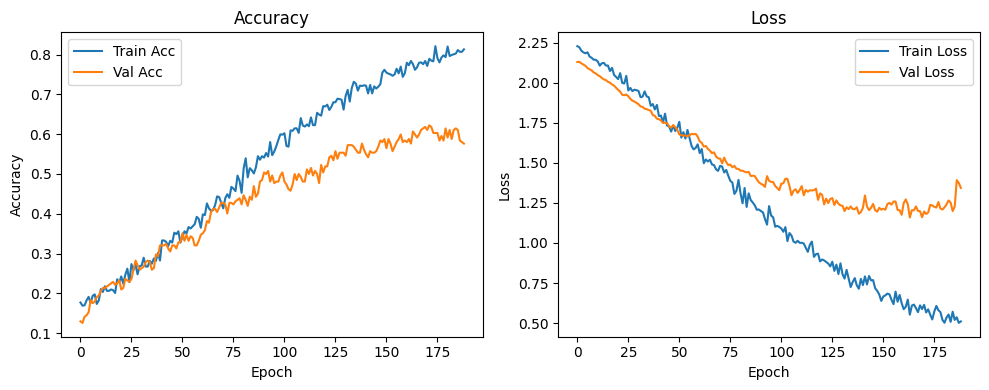

In [25]:
# 1. Plot training curves
def plot_training_curves(history):
    plt.figure(figsize=(10, 4))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_training_curves(history)

In [26]:
# 2. Classification report
report = classification_report(y_true, y_pred, target_names=columbia_class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
center,0.000000,0.000000,0.000000,9.000000
down,0.214286,0.214286,0.214286,14.000000
down_left,0.687500,0.687500,0.687500,32.000000
down_right,0.500000,0.565217,0.530612,23.000000
left,0.674419,0.630435,0.651685,46.000000
right,0.555556,0.609756,0.581395,41.000000
up,0.086957,0.181818,0.117647,11.000000
up_left,0.653846,0.447368,0.531250,38.000000
up_right,0.729730,0.613636,0.666667,44.000000
accuracy,0.534884,0.534884,0.534884,0.534884


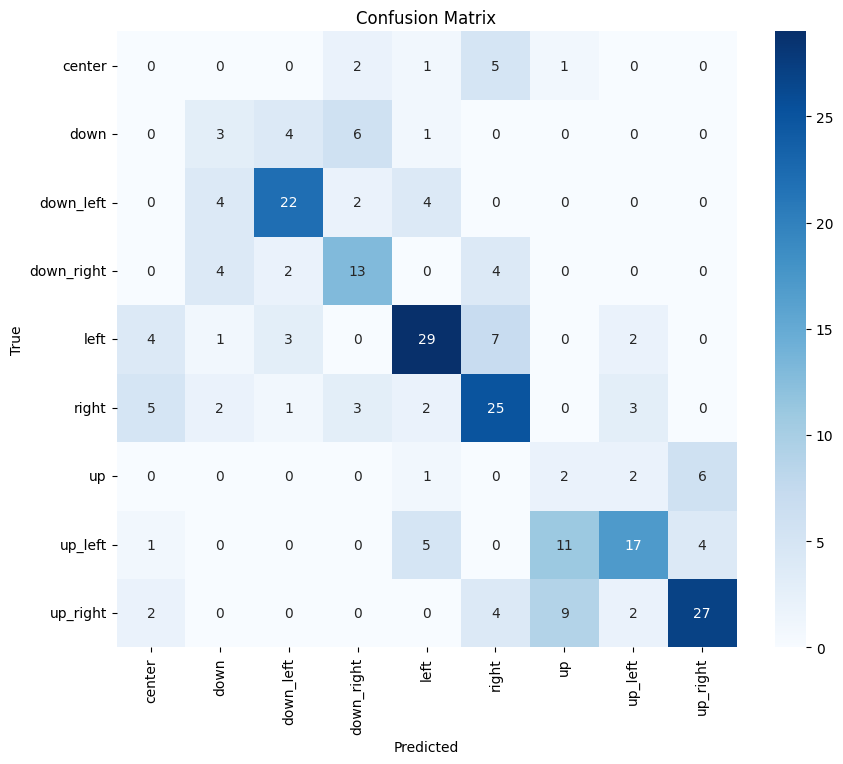

In [27]:
# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


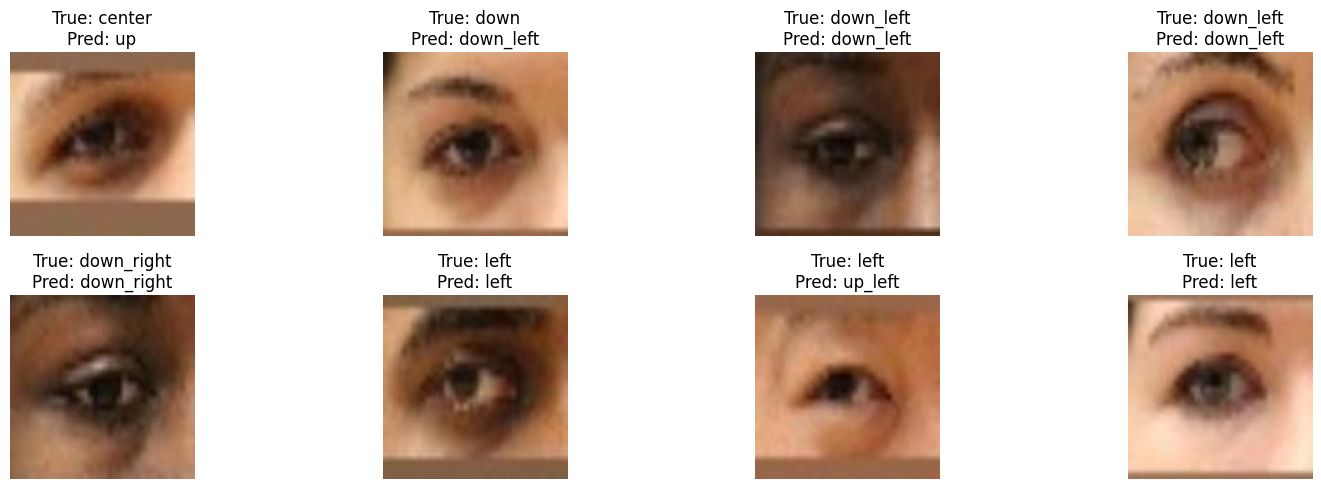

In [28]:
# 4. Inference examples
def plot_inference_examples(generator, y_pred, class_names, num_examples=8):
    fig, axes = plt.subplots(2, num_examples // 2, figsize=(16, 5))
    axes = axes.flatten()
    for i in range(num_examples):
        img, label = generator[i]
        pred_label = class_names[np.argmax(model.predict(np.expand_dims(img[0], axis=0)))]
        true_label = class_names[np.argmax(label[0])]
        axes[i].imshow(img[0])
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Display
plot_inference_examples(columbia_test_gen, y_pred, class_names)

In [19]:
!tensorflowjs_converter --input_format=keras $COLUMBIA_BEST_MODEL_PATH $COLUMBIA_TFJS_MODEL_PATH

2025-05-27 12:24:57.202127: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748348697.223875   26596 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748348697.230422   26596 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
usage: TensorFlow.js model converters. [-h]
                                       [--input_format {keras,tf_saved_model,keras_keras,tfjs_layers_model,tf_frozen_model,tf_hub,keras_saved_model}]
                                       [--output_format {keras,keras_keras,tfjs_layers_model,tfjs_graph_model,keras_saved_mo